In [1]:
import folium
import pandas as pd
import numpy as np
import geopandas as gpd
import os

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec

import networkx as nx



In [13]:
%%time


# Load & Read GeoJSON file

# file_path = "/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/physical_grid_data/US_Electric_Power_Transmission_Lines_-3845977064911730921.geojson"
# gdf = gpd.read_file(file_path)
# # gdf = gdf.to_crs(epsg=3857)
# gdf = gdf.to_crs(epsg=4326)
 

# # Convert timeframes to folium-friendly types
# gdf['SOURCEDATE'] = pd.to_datetime(gdf['SOURCEDATE']).dt.strftime('%Y-%m-%dT%H:%M:%S')
# gdf['VAL_DATE'] = pd.to_datetime(gdf['VAL_DATE']).dt.strftime('%Y-%m-%dT%H:%M:%S')


file_path = "/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/physical_grid_data/U.S._Electric_Power_Transmission_Lines.geojson"
gdf = gpd.read_file(file_path)
# gdf = gdf.to_crs(epsg=3857)
# gdf = gdf.to_crs(epsg=4326)

 

# # Convert timeframes to folium-friendly types
# gdf['SOURCEDATE'] = pd.to_datetime(gdf['SOURCEDATE']).dt.strftime('%Y-%m-%dT%H:%M:%S')
# gdf['VAL_DATE'] = pd.to_datetime(gdf['VAL_DATE']).dt.strftime('%Y-%m-%dT%H:%M:%S')




In [17]:
gdf['geometry'][0]

In [16]:
# Plot the GeoDataFrame
map = gdf.plot(figsize=(20, 16),linewidth=0.5)

# Define common voltages and corresponding colors
common_voltages = [0, 44, 115, 161, 169, 230, 345]

hex_colors = ['blue','green', 'cyan', 'yellow', 'orange', 'red']
legend_labels = ['<' + str(i) for i in common_voltages[1:]]

# Plot overlays for each common voltage
for voltage, color, label in zip(common_voltages, hex_colors, legend_labels):
    overlay = gdf[gdf['VOLTAGE'] > voltage]  # Filter GeoDataFrame based on voltage
    overlay.plot(ax=map, marker='o', color=color, markersize=5, linewidth=0.5, label=label)
    
# Create a custom legend with colored patches
legend_handles = [Patch(color=color, label=label) for color, label in zip(hex_colors, legend_labels)]

# Add legend
map.legend(handles=legend_handles, title='Voltage', loc='upper right')

# Set xy axis limits
map.set_xlim((-130, -65))
map.set_ylim((25,50))

# Put labels on the map
map.set_xlabel("Longitude")
map.set_ylabel("Latitude")
map.set_title("Major US Transmission Lines")


In [108]:
# Convert datetime strings to numeric timestamps
gdf['timestamp'] = pd.to_datetime(gdf['SOURCEDATE']).apply(lambda x: int(x.timestamp()))

# Create an initial Folium map
map_center = [39.8283, -98.5795]
initial_map = folium.Map(location=map_center, zoom_start=4)

folium.GeoJson(gdf).add_to(initial_map)

In [5]:
# display(initial_map)


In [110]:
multilines = gdf['geometry']
for idx, multiline in multilines.items():
    for line in multiline.geoms:  # Iterating over the line strings in the MultiLineString
        x_coords, y_coords = line.xy

AttributeError: 'LineString' object has no attribute 'geoms'

In [122]:
for line in multiline.xy:
    print(line)
    x_coords, y_coords = line
x_coords = multiline.xy[0]
y_coords = multiline.xy[1]
print(y_coords)

array('d', [-70.92855369023208, -70.9284093004232])
array('d', [42.54359004407545, 42.544105501192305])
array('d', [42.54359004407545, 42.544105501192305])


### Analyze the physical network

In [123]:
gdf_exploded = gdf.explode()

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_15557/2915452980.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_exploded = gdf.explode()


In [26]:
gdf['SUB_1'].values

array(['Waters River', 'Phillips Bend', 'Tap140359', ..., 'Tap204261',
       'Tap161754', 'Unknown202234'], dtype=object)

In [106]:
subs1 = [s1 for s1 in gdf['SUB_1'].values]
subs2 = [s2 for s2 in gdf['SUB_2'].values]
subs_total = list(set(subs1+subs2))

In [107]:
len(subs_total)

67802

In [133]:
gdf

OBJECTID_1  OBJECTID      ID          TYPE         STATUS NAICS_CODE  \
0               1         1  100511  AC; Overhead     In Service     221121   
1               2         2  140809  AC; Overhead     In Service     221121   
2               3         3  140837  AC; Overhead     In Service     221121   
3               4         4  140811  AC; Overhead     In Service     221121   
4               5         5  140813  AC; Overhead     In Service     221121   
...           ...       ...     ...           ...            ...        ...   
94211       94212     94212  313969  AC; Overhead     In Service     221121   
94212       94213     94213  313970  AC; Overhead     In Service     221121   
94213       94214     94214  202495  AC; Overhead  Not Available     221121   
94214       94215     94215  202496  AC; Overhead  Not Available     221121   
94215       94216     94216  166911  AC; Overhead  Not Available     221121   

                                         NAICS_DESC  \
0      Electric Bulk Power Transmission and Control   
1      Electric Bulk Power Transmission and Control   
2      Electric Bulk Power Transmission and Control   
3      Electric Bulk Power Transmission and Control   
4      Electric Bulk Power Transmission and Control   
...                                             ...   
94211  Electric Bulk Power Transmission and Control   
94212  Electric Bulk Power Transmission and Control   
94213  Electric Bulk Power Transmission and Control   
94214  Electric Bulk Power Transmission and Control   
94215  Electric Bulk Power Transmission and Control   

                                                  SOURCE           SOURCEDATE  \
0                              Imagery, EIA 861, EIA 860  2016-11-08T00:00:00   
1                                       Imagery, EIA 860  2014-04-16T00:00:00   
2      Imagery, https://www9.nationalgridus.com/oasis...  2015-06-16T00:00:00   
3                                 Imagery, OpenStreetMap  2014-06-20T00:00:00   
4                                       Imagery, EIA 860  2016-10-04T00:00:00   
...                                                  ...                  ...   
94211                                            Imagery  2018-08-28T00:00:00   
94212                                            Imagery  2018-10-16T00:00:00   
94213                                            Imagery  2019-04-10T00:00:00   
94214                                            Imagery  2019-04-10T00:00:00   
94215                                            Imagery  2019-04-10T00:00:00   

          VAL_METHOD  ...                                            OWNER  \
0            Imagery  ...                                    Not Available   
1            Imagery  ...                               Kingsport Power Co   
2            Imagery  ...                       Niagara Mohawk Power Corp.   
3            Imagery  ...                         Entergy New Orleans, Llc   
4      Imagery/other  ...                            Midamerican Energy Co   
...              ...  ...                                              ...   
94211  Imagery/other  ...      Sulphur Springs Valley Electric Cooperative   
94212  Imagery/other  ...  Graham County Electric Cooperative Incorporated   
94213        Imagery  ...                            City Of Gering - (Ne)   
94214        Imagery  ...                            City Of Gering - (Ne)   
94215        Imagery  ...                            City Of Gering - (Ne)   

      VOLTAGE  VOLT_CLASS INFERRED          SUB_1            SUB_2  \
0       115.0     100-161      Yes   Waters River        Tap136228   
1       161.0     100-161      Yes  Phillips Bend      John Sevier   
2       115.0     100-161      Yes      Tap140359        Tap140373   
3       115.0     100-161      Yes  Gentilly Road  Michoud Station   
4       161.0     100-161      Yes  Unknown137689        Tap137690   
...       ...         ...      ...            ...              ... 

In [238]:
for g in range(0,100):
    print('Sub {} to Sub {} has geometry {}'.format(gdf['SUB_1'].values[g],gdf['SUB_2'].values[g],gdf['geometry'].values[g]))

Sub Waters River to Sub Tap136228 has geometry LINESTRING (-70.92855369023208 42.54359004407545, -70.9284093004232 42.544105501192305)
Sub Phillips Bend to Sub John Sevier has geometry LINESTRING (-82.96123095595433 36.3769930829573, -82.96089816068428 36.376700848959956, -82.9596644216596 36.377098316118385, -82.9566694241293 36.3779402847695, -82.9544144380688 36.378547855190284, -82.95098278924182 36.37837807327446, -82.94868338598211 36.377595833761646, -82.9444899999302 36.376029501980796, -82.94054314572821 36.37423708327015, -82.93692975873608 36.37132902626808, -82.93402876720533 36.36896701592318, -82.93186887500418 36.36700924274721, -82.93014096196192 36.36789697827601, -82.92871028168423 36.36856674188477, -82.9256314228289 36.37078304588974, -82.914224406942 36.37880170178426, -82.91192227819371 36.38084684921378, -82.90450192894389 36.38753908285495, -82.90323843502203 36.3894664459091, -82.90143956315717 36.39906043289521, -82.89551827394445 36.40382530279326, -82.893922

In [248]:
line_tmp = gdf['geometry'].values[g]
print(line_tmp)

for pt1,pt2 in zip(line_tmp.coords, line_tmp.coords[1:]):
    print(pt1,pt2)

LINESTRING (-83.13942499959073 34.430462999746666, -83.13935048164296 34.43063041100642, -83.141484399956 34.431870500079064, -83.14358719972925 34.433122700330685, -83.14746029955145 34.435458800156404)
(-83.13942499959073, 34.430462999746666) (-83.13935048164296, 34.43063041100642)
(-83.13935048164296, 34.43063041100642) (-83.141484399956, 34.431870500079064)
(-83.141484399956, 34.431870500079064) (-83.14358719972925, 34.433122700330685)
(-83.14358719972925, 34.433122700330685) (-83.14746029955145, 34.435458800156404)


In [241]:
print(gdf['geometry'].values[g].exploded)

AttributeError: 'LineString' object has no attribute 'exploded'

In [131]:
print(gdf['geometry'][0].coords[0])
print(gdf['geometry'][0].coords[1])


(-70.92855369023208, 42.54359004407545)
(-70.9284093004232, 42.544105501192305)


In [147]:
for _, row in gdf_exploded.iterrows():
    if row['geometry'].geom_type == 'MultiLineString':
        # If the geometry is a multi-part linestring, iterate over each part
        print(row['geometry'])
#         for line in row['geometry']:
#             print('multilinestring, line = {}'.format(line))

In [144]:
print(row['geometry'].values)
print(row['SUB_1'])
print(row['SUB_2'])

AttributeError: 'MultiLineString' object has no attribute 'values'

In [148]:
for _, row in gdf_exploded.iterrows():
    if row['geometry'].geom_type == 'MultiLineString':
        print('exploded GDF should not reach here')
    elif row['geometry'].geom_type == 'LineString':
        print(row['geometry'].coords[0])

(-70.92855369023208, 42.54359004407545)
(-82.96123095595433, 36.3769930829573)
(-75.3340663089588, 43.08946163671524)
(-89.93727857139062, 30.009051135160774)
(-90.56608759936212, 41.612560400756344)
(-86.83214468570017, 33.855089844755796)
(-71.02485606390991, 42.394873509853)
(-75.33410000027352, 43.08901599996714)
(-90.53585083420973, 41.81095259705799)
(-81.78569824494853, 41.40841954286767)
(-90.06720340123788, 31.589483328382542)
(-94.48205922116495, 39.13329544387411)
(-80.5960297937522, 34.27358118263512)
(-90.24758674342627, 32.33969076694672)
(-83.13040331800701, 38.312087521671046)
(-83.55530313261214, 41.594283425209596)
(-90.17901807188811, 36.58693183009219)
(-103.84608401297604, 44.40318514273074)
(-86.84447155937002, 33.30877297680985)
(-79.72569149980579, 34.96080750028461)
(-82.28903053294879, 34.82895261015645)
(-94.2551417270227, 39.00924585694064)
(-100.97189291113051, 37.92639117000692)
(-93.51582520559846, 32.525431948691306)
(-97.65605799965513, 44.8988329998888

(-79.70762478044094, 35.790509594967666)
(-95.75100329819387, 34.94738274584047)
(-101.4239261044322, 41.098305315014215)
(-76.14296005037214, 40.19901418809314)
(-81.91038432463765, 39.866464156679186)
(-86.63911475134749, 30.741959881225352)
(-84.38325558768723, 42.72765059886569)
(-87.76566679813045, 43.789307829888955)
(-76.68896132891619, 38.56030499180836)
(-103.98152699957754, 46.222418000138866)
(-82.17509678595066, 35.265345379962184)
(-72.86641492336156, 41.58843888387615)
(-77.67071675576194, 36.47468480628676)
(-79.72653552989728, 41.44849665815582)
(-84.11936933299215, 37.13512683926265)
(-84.37879648895742, 34.386529415075195)
(-94.22779998589264, 39.32571013380076)
(-92.55399424287124, 44.035586444312514)
(-85.82145211157642, 33.629869277110494)
(-80.34361755578946, 35.8058205457318)
(-76.90595623904257, 39.089945939345135)
(-90.81700940830096, 29.819418339240002)
(-84.07318615102318, 35.90429772221598)
(-82.47208399963992, 29.571757999627938)
(-94.4342875922965, 36.1081

(-82.76128599985194, 37.64353499966814)
(-87.52475006819496, 38.016645454758134)
(-87.64030682836635, 38.0140750002355)
(-89.63670366522135, 39.82637524304069)
(-75.37978232116595, 41.034613761854395)
(-75.47927461960421, 41.35492585179321)
(-89.61691308960606, 39.81390978520885)
(-89.62596051780415, 39.84146049494386)
(-90.17667250330763, 38.66400973065381)
(-90.14292284030408, 38.66893713370391)
(-89.77406372131787, 38.36942585179938)
(-89.84844068837906, 38.303696536925315)
(-90.17667250330763, 38.66400973065381)
(-90.13612539724528, 38.61471547377774)
(-90.13612539724528, 38.61471547377774)
(-88.92699818294678, 37.75510011177592)
(-75.3726837547391, 41.049543456318894)
(-75.3726837547391, 41.049543456318894)
(-87.99719688164355, 40.76471351232569)
(-87.58387581924806, 40.74624474129413)
(-88.75599526904242, 37.96956562018141)
(-84.82793999961945, 45.063713999741964)
(-87.49051499962931, 40.76860500015181)
(-87.57807522857523, 40.71699694093252)
(-90.01496113028824, 38.5132580190793

(-95.72381309027584, 39.01512024905863)
(-95.67254591541425, 39.075605539846585)
(-95.66603494869284, 39.05650581726534)
(-95.67254591541425, 39.075605539846585)
(-95.93499760282141, 39.75372705880813)
(-97.54635977508566, 39.503391588760174)
(-97.54424557569145, 39.427651154658044)
(-99.36838215638329, 36.311798882788445)
(-79.08144020033494, 36.47653279996084)
(-96.40570696491604, 36.01070691016187)
(-99.36838215638329, 36.311798882788445)
(-97.68868616363719, 37.4301685543507)
(-97.68868616363719, 37.4301685543507)
(-77.64717949933605, 36.47985987899627)
(-77.44708014888748, 36.51208680924463)
(-77.42169891169472, 34.77054131076587)
(-77.42282790356404, 34.777677998641856)
(-76.30061334697761, 36.271764538830205)
(-89.40852560297014, 31.32199281802659)
(-77.71277809979642, 34.403728600231055)
(-78.91381101727791, 36.48984104981525)
(-78.86341270014566, 36.47459149990363)
(-79.05584360013765, 36.45329239980038)
(-98.75361878285074, 35.93201070020427)
(-95.40386943039921, 35.973591794

(-73.93052139524598, 42.9771610248915)
(-78.49363109670261, 42.26584328175251)
(-79.84048757737438, 34.50626511967577)
(-78.5809986208504, 42.8321903138579)
(-76.38616866107517, 39.6990365692858)
(-81.37223706692829, 38.26657980518803)
(-76.540392862764, 39.68741801379712)
(-88.78351185376779, 33.60977017162779)
(-88.80255886058477, 33.505333039758284)
(-73.08632172607467, 41.7377419950521)
(-70.76915000024437, 43.11611699995281)
(-70.72966837156748, 43.121303064685144)
(-70.67916087589056, 43.14855057132757)
(-70.44766123897739, 43.49480051609043)
(-69.38916370399657, 45.160292394705095)
(-68.16067257521517, 46.09811667397186)
(-68.27776999999774, 46.016462000302134)
(-76.71745826577241, 40.001262774163216)
(-76.23274088236104, 38.96610939367768)
(-67.66713421721076, 46.54338492782155)
(-68.74304423661984, 44.82960989881914)
(-68.43193199964136, 45.89702100019963)
(-67.95238534775149, 46.70897683175321)
(-68.27776999999774, 46.016462000302134)
(-68.77485836795266, 44.82091257105054)
(

(-100.76144277402466, 37.165363612697476)
(-87.2844857307514, 37.98973342677122)
(-86.16640032258924, 40.094113054131775)
(-86.07574932941557, 40.101143472980446)
(-86.2030690000231, 39.977512999880034)
(-86.23791625698016, 39.96296785580244)
(-93.23246020028616, 42.62875246121573)
(-86.67399034476185, 33.694983227054706)
(-78.6402645135794, 43.178838177258044)
(-94.34453122592438, 34.02777533619218)
(-85.29919618778708, 34.54091549094372)
(-88.40185729985956, 43.784097322265204)
(-91.97240109562777, 41.00608226131029)
(-97.4468701158977, 35.174413440231405)
(-101.33144797030997, 47.277020404191184)
(-92.10795940435219, 32.4075041018623)
(-80.96711685591558, 40.24183828615102)
(-87.43308962825505, 32.14659465695813)
(-87.9766377919128, 42.31112176213397)
(-93.8118722209518, 41.660034306891994)
(-87.85631716787336, 32.47666131187947)
(-100.97189291113051, 37.92639117000692)
(-86.25033704322476, 39.94026779789722)
(-91.37397687606581, 30.6830310411336)
(-76.77207308710041, 39.01527563719

(-85.7084442087343, 34.172622521645486)
(-97.83889204385497, 39.797768878127656)
(-79.60587637484471, 33.474549738695515)
(-98.4272895152523, 36.375366565264805)
(-78.96165529919159, 33.765079214975195)
(-71.177050518621, 41.72788443088847)
(-81.08921800013695, 34.36885599997797)
(-84.85497575300417, 39.350297443753206)
(-76.3031298020746, 43.042550674138845)
(-84.86280569090442, 39.0851749783424)
(-82.52193985830806, 42.85108550606127)
(-83.54571027342467, 30.06158929829176)
(-78.93040677231448, 40.193119757197984)
(-77.46011623798255, 37.616885131811166)
(-89.79785499974653, 43.97431100027873)
(-74.11705482575331, 40.7919219700461)
(-84.15519660072019, 32.196812856130336)
(-75.57775637443329, 40.51917922790664)
(-83.59267903390625, 32.60025267320512)
(-78.99034164941871, 39.55691717820713)
(-98.42659667880963, 36.39118818199689)
(-83.34612491472717, 33.97661739099344)
(-92.09045455334979, 40.453601644142346)
(-79.41317169889683, 36.10532142623915)
(-71.04165486964172, 42.505261779084

(-75.0914588858782, 42.44381614084895)
(-94.3435021878001, 34.02816419617817)
(-94.30274599975371, 34.24208699968787)
(-78.9428886035742, 36.42004302709301)
(-81.8415150525509, 37.90577057674879)
(-98.52852999991215, 44.88683100012753)
(-94.30274599975371, 34.24208699968787)
(-82.66154596761788, 34.796984096093624)
(-83.34775930416521, 36.04752844527602)
(-94.31043699972055, 34.28876099991285)
(-81.17538717888223, 32.35189548220549)
(-87.6239990031413, 34.82743899281104)
(-72.04465500020598, 44.13963199990486)
(-94.40657414267493, 34.451614638031906)
(-91.84798912696617, 46.955932140195124)
(-85.94602599977136, 37.846425000319975)
(-87.74702155204454, 42.024660438320545)
(-78.47002499968157, 43.01290399986715)
(-90.50411575013034, 38.824997240949145)
(-81.0634109992288, 35.02538849504286)
(-71.10545754560967, 41.86529405083033)
(-80.7484204782506, 36.75858586225398)
(-77.35839012497841, 35.661922214846186)
(-78.5132492451907, 34.975988675195765)
(-84.29641030002819, 33.48453289963834)


(-94.05031899977593, 46.72371300005514)
(-92.38970180971626, 43.841463544166686)
(-80.64674179629345, 40.25508471800629)
(-86.93627500032339, 37.75634499999084)
(-84.26217819230973, 37.88052993697663)
(-91.77700192029025, 42.10071379302842)
(-74.95755514634637, 44.58342945396942)
(-94.13359499963849, 46.73250100017907)
(-83.27357051259646, 39.71706695014645)
(-82.38238329557772, 29.613954415826317)
(-74.69924700556085, 40.79420234201673)
(-82.79129839099919, 27.972347746973064)
(-80.64618750971201, 34.22881287898299)
(-73.09688667828223, 41.52256489769587)
(-84.6255320157216, 33.83531465363277)
(-89.18316399988315, 44.400638999769384)
(-70.97556489341588, 42.50699043029948)
(-93.0593859824407, 31.765132351866892)
(-76.90196486703005, 38.62795107305769)
(-83.16395500040677, 39.678492999782684)
(-84.1214962462426, 33.75634064497482)
(-79.16926359433657, 34.92979902981361)
(-80.68906183626514, 35.70975124773647)
(-77.88580089987164, 34.21702750036377)
(-81.93077848907211, 38.4393491887485

(-76.59843887657483, 42.849770510802486)
(-95.54404525126223, 34.87232617681246)
(-96.8417649998036, 46.688387999991534)
(-98.03607699990873, 40.872149000338815)
(-95.29086040017141, 44.123164904833615)
(-88.7593972968212, 40.370593352694456)
(-93.55650982037461, 32.16290787008422)
(-71.99329870168843, 44.3194191242705)
(-91.4524049998183, 44.85913100023375)
(-75.29390640103843, 43.086124089715234)
(-91.85218718066429, 32.79363395209551)
(-84.12683307087022, 33.59219569914872)
(-81.17036736971838, 35.4454584376545)
(-81.96092953877671, 35.14157080805931)
(-88.16731942680653, 33.12030753510189)
(-79.78109031501823, 36.1224182861465)
(-90.37911439860744, 33.64136729815192)
(-82.1022307169254, 35.35433614827352)
(-86.1886671563875, 39.81006146782284)
(-80.37757056323737, 35.71284785580081)
(-84.76421669519674, 42.252302659249146)
(-81.92232234097717, 27.95236782317021)
(-91.87413796917927, 44.90027458468656)
(-82.63908968810937, 35.821497766324036)
(-92.29733199984086, 44.758500000265165)

(-88.28122021821012, 37.68651948126117)
(-99.23681123204983, 35.0367773156811)
(-86.28517559730332, 31.237938639702037)
(-87.52102027391507, 41.70676865101097)
(-82.01046976359001, 28.094651678371356)
(-89.36491164583288, 43.22073890793714)
(-90.21142928374589, 38.6960547951555)
(-99.39887384544701, 35.38812541720245)
(-88.29743500042964, 37.46142099979589)
(-94.1051838276374, 45.479743960865335)
(-88.1670680000366, 37.53989399989901)
(-88.40618500021613, 37.448929000187746)
(-97.51138480284804, 35.27444435989202)
(-85.21736550355483, 31.87361825820013)
(-88.67926200032973, 37.37642299976883)
(-79.41517629124998, 36.60266246189399)
(-88.40618500021613, 37.448929000187746)
(-80.78310462540654, 36.26143572782731)
(-91.4671858552487, 34.79361481636246)
(-87.10219277418655, 35.42511764284805)
(-84.33315412782378, 33.605777487279205)
(-81.76643951240564, 35.03382403014144)
(-86.11461293514328, 35.33745991833379)
(-81.22881577667421, 41.59554045692292)
(-78.18067350902648, 34.84946922368936)

(-81.74302225742699, 26.140464566136227)
(-82.43066309870744, 27.357966738726006)
(-83.76437099965098, 32.4598069999473)
(-79.87277912105988, 37.34950126905973)
(-95.74962623655885, 38.19311432275204)
(-86.71208886704017, 33.81728396023279)
(-96.73925952013705, 34.73778913914491)
(-86.12513642201564, 30.361234905204125)
(-81.09067000013128, 32.09460400014124)
(-78.66631320441813, 38.353003801198376)
(-78.91858021893539, 42.97857471773353)
(-81.55348599967333, 38.243836000043224)
(-79.27157681297275, 39.20299547773255)
(-87.49198157658576, 37.97626433305157)
(-102.99917631488857, 42.84759672409048)
(-80.0924380606198, 40.651263662210646)
(-101.53267594072531, 39.75645205715208)
(-87.47518700012232, 36.87589799978437)
(-92.79141906768545, 45.03293239300326)
(-70.9491633479268, 41.71940619525624)
(-84.1808410505794, 35.89414606024211)
(-78.68282111320305, 35.79100546466598)
(-77.98395034002934, 34.28182291013794)
(-81.7913473167824, 33.548405489727685)
(-85.0104836283694, 37.1116468768830

(-94.00588097221447, 37.16326324734056)
(-93.03903959670124, 37.264903839799)
(-93.11831198590384, 37.09286037520159)
(-93.11831198590384, 37.09286037520159)
(-93.22601304179769, 37.08501581104361)
(-92.6655765516968, 36.97604059893332)
(-92.6655765516968, 36.97604059893332)
(-93.30525102911817, 37.604989488790274)
(-89.86403698142378, 36.364342526313855)
(-93.29197053807869, 37.940682195770115)
(-93.30525102911817, 37.604989488790274)
(-93.30777440573442, 37.45769011272818)
(-93.30777440573442, 37.45769011272818)
(-92.75225099955173, 37.994988000300125)
(-95.14283101391955, 39.991956931252)
(-95.11044270371163, 35.89328910295235)
(-95.3222300001859, 35.71370199985636)
(-89.98299789478793, 36.602839884665386)
(-89.9735210000188, 36.60398399987627)
(-89.9735210000188, 36.60398399987627)
(-89.86571470828606, 36.60549110017149)
(-89.68135481359239, 36.49078771904121)
(-89.70237259298868, 36.36501496228003)
(-95.75100329819387, 34.94738274584047)
(-94.62970116583142, 35.11518709924506)
(-8

(-76.35971347179058, 40.0936403447668)
(-95.14486164573783, 45.088199651799286)
(-92.81293498177139, 44.59924182904739)
(-84.3535664813461, 39.443055916131804)
(-95.08389819763329, 45.08878415172882)
(-93.324859418309, 44.74252945187193)
(-95.5532721466844, 44.8277277833175)
(-94.3087370287752, 46.61644310517194)
(-76.735487055571, 39.94786988596236)
(-95.49331078814393, 45.02086541130709)
(-94.22044803886011, 46.61673869814424)
(-94.22044803886011, 46.61673869814424)
(-93.29755430778128, 44.71743336127968)
(-92.98579137433012, 45.31180882314341)
(-92.9125593487261, 45.461579274897844)
(-92.95685946602683, 45.195697743942695)
(-96.29972700025819, 46.97751800025392)
(-95.5429319915885, 44.036329893720385)
(-96.11597673914724, 46.659862097001046)
(-90.70749768386594, 47.643389778905956)
(-95.42132611283778, 44.036108099104084)
(-95.42132611283778, 44.036108099104084)
(-94.92943365169018, 43.984869681104215)
(-94.79086050793903, 43.96371058086591)
(-94.29373375227709, 46.39089792394515)
(

(-85.49289580809923, 42.280817533205195)
(-85.49289580809923, 42.280817533205195)
(-85.55074539808666, 42.27017198884029)
(-95.05426661131813, 45.12156924769892)
(-93.32195810338474, 30.19664138268851)
(-73.2901579162899, 40.88129217928772)
(-82.43533465259523, 34.60226573364846)
(-73.9093125998843, 40.787692859154)
(-73.9093125998843, 40.787692859154)
(-73.90560811114598, 40.78736711316907)
(-93.63449943511444, 42.56327963620061)
(-80.88968599957069, 34.55588000010326)
(-80.89329305882993, 34.55900463324047)
(-80.87551681240714, 34.541346160069004)
(-89.03244382428373, 42.5064269849712)
(-73.63942968373091, 43.305533391708856)
(-73.63703159065577, 43.308088370962594)
(-73.64092751577103, 43.306618558743985)
(-72.85224837904158, 40.85843516683727)
(-89.20035753882553, 34.82897661077878)
(-75.45621303639264, 40.60792233166039)
(-76.26854245917028, 39.75803887419269)
(-76.26857517671122, 39.75901742713122)
(-80.51872165985152, 38.080709206243554)
(-87.64924788525501, 45.35470668083484)
(

(-114.42060848314301, 42.83567352998158)
(-113.68722650108195, 42.74467372971074)
(-114.42060848314301, 42.83567352998158)
(-113.68722650108195, 42.74467372971074)
(-114.42060848314301, 42.83567352998158)
(-114.42060848314301, 42.83567352998158)
(-114.4265632660411, 42.83467157673863)
(-112.93046075862591, 42.75030478068651)
(-112.93046075862591, 42.75030478068651)
(-112.5587366687552, 42.89269036813936)
(-112.5587366687552, 42.89269036813936)
(-112.12113890170771, 43.306245975110855)
(-111.59628125203969, 42.7104333217593)
(-112.15514172343306, 42.42474194811404)
(-112.15514172343306, 42.42474194811404)
(-112.15514172343306, 42.42474194811404)
(-112.15514172343306, 42.42474194811404)
(-112.15514172343306, 42.42474194811404)
(-112.04724778756962, 41.340060929232806)
(-112.04724778756962, 41.340060929232806)
(-112.04724778756962, 41.340060929232806)
(-112.04724778756962, 41.340060929232806)
(-112.04356570011956, 41.09473538121953)
(-112.00609523497208, 40.75837222682985)
(-112.006095234

(-117.5736401032015, 47.671470538252436)
(-111.80291898219888, 40.44878368917308)
(-111.79185891992924, 40.430144790053454)
(-111.7890742036339, 40.34935647628774)
(-111.86869062513243, 40.4060741600442)
(-111.86827588464385, 40.418719805669646)
(-111.73353153939837, 40.316416360849885)
(-111.7352213180585, 40.28490190984717)
(-109.317610775806, 37.86860590398908)
(-109.54839189973073, 37.30420130005917)
(-109.54839189973073, 37.30420130005917)
(-109.37285800031425, 37.28180258906419)
(-109.37285800031425, 37.28180258906419)
(-109.37285800031425, 37.28180258906419)
(-109.29770453580966, 37.208842692977505)
(-109.38027800011943, 37.207681000248876)
(-109.3079704137063, 38.16008149571894)
(-109.3104767780277, 38.146142137260725)
(-109.3079704137063, 38.16008149571894)
(-109.31724053785659, 38.30015969067251)
(-109.2993207514312, 38.259569087130025)
(-109.3079704137063, 38.16008149571894)
(-109.31778916056017, 38.299934988689934)
(-109.31778916056017, 38.299934988689934)
(-109.60740333028

(-112.47826799488537, 48.624474952053426)
(-112.47826799488537, 48.624474952053426)
(-112.47826799488537, 48.624474952053426)
(-112.36084189091338, 48.50562706095955)
(-112.35335896142759, 48.62392997014986)
(-112.35200680288888, 48.62434403912727)
(-122.98186855367136, 48.51823702614503)
(-122.9153755896158, 48.547894830761486)
(-122.92883176597203, 48.56581194513159)
(-122.94810877114612, 48.572911860197486)
(-122.94810877114612, 48.572911860197486)
(-122.95549461790254, 48.585675289237024)
(-122.94506076133595, 48.59927993704121)
(-122.9446796106525, 48.62867060291611)
(-122.9446796106525, 48.62867060291611)
(-122.82388554481392, 48.61778411882617)
(-122.80921761480124, 48.585577163709516)
(-122.81457164036993, 48.52426690122431)
(-122.80471264539811, 48.50683558698876)
(-122.80471264539811, 48.50683558698876)
(-122.8216202784333, 48.50537052711164)
(-122.7971301520361, 48.50695572375509)
(-123.011927094868, 48.52923132472283)
(-122.69026829329754, 48.50060231475623)
(-122.650396769

(-93.96222200139664, 29.834999999687327)
(-93.97314200104213, 29.89656499974038)
(-121.42218949600817, 38.61274376234033)
(-106.46474911306481, 35.385859866322974)
(-95.22735048335794, 29.71718769609206)
(-121.79636454570681, 37.24497153472233)
(-93.95045116422641, 29.88482726996139)
(-105.95724386400727, 35.653808125775)
(-106.4461793748701, 31.861168116053474)
(-117.04672167066097, 32.74375919191136)
(-93.79818600042434, 30.698379999967454)
(-93.94009657140724, 29.924721168955784)
(-93.96214100120578, 29.87070799985316)
(-93.9453966288886, 29.888905582302332)
(-93.95778316596467, 29.891717145640023)
(-93.97209644469643, 29.87393290600951)
(-93.8899277217278, 29.945671946133547)
(-93.8899277217278, 29.945671946133547)
(-103.09309306680235, 32.71171046786292)
(-122.08039899982333, 38.228647999272816)
(-119.34104638397014, 36.20499462526743)
(-93.8792346437096, 30.024429078351346)
(-93.882787528269, 29.953801276983942)
(-93.97209644469643, 29.87393290600951)
(-93.96984543098611, 29.8708

(-120.09984600026434, 36.61702199998151)
(-122.78644432432056, 38.04217183211563)
(-103.08150507991158, 31.84839712521795)
(-98.31027501575022, 32.658849529863055)
(-121.76329382041182, 37.2146459642894)
(-104.43853100074095, 32.92977000033486)
(-99.68823286128924, 29.228010390292578)
(-123.98060485858733, 40.87983812097001)
(-121.42956700011052, 38.532028999942796)
(-121.17871402278368, 38.60317184369093)
(-115.78897423126595, 32.82670446275969)
(-120.12875217003811, 36.14232774883947)
(-112.05803946197848, 33.50149424402746)
(-98.01705924762732, 29.651184760752525)
(-96.93538502200936, 32.724366363813175)
(-121.86411688670526, 37.36086726197157)
(-122.32900687615107, 40.4508796047279)
(-98.71819022068344, 29.416135657964748)
(-111.94234019396872, 33.35217457298387)
(-121.94196156635881, 37.43269340634714)
(-97.66586136375807, 30.419677556159225)
(-114.47834399966577, 32.669963998768175)
(-98.9715915998937, 29.19203799999286)
(-117.13718306091923, 32.78390711614498)
(-99.3312198070901

(-95.04664161506679, 29.626225488643684)
(-121.56443417559807, 38.58316496167057)
(-100.3521404966309, 32.43783246771341)
(-117.13718306091923, 32.78390711614498)
(-118.58171253328828, 34.43976898588138)
(-121.85411033715978, 37.669074829128455)
(-94.49609475338727, 32.467544730002196)
(-97.79407009969727, 33.26473450008252)
(-97.68721274061996, 30.265280870078183)
(-120.97952398479495, 37.63492167306598)
(-97.00539519403281, 32.86756367084108)
(-106.28571156664798, 31.617995050867588)
(-97.21375711641238, 32.63679996964321)
(-95.52483532598534, 29.818405706175593)
(-93.97106279911306, 29.87358849489964)
(-97.13085258519116, 32.65617156770471)
(-95.32202833109956, 29.677967719700206)
(-96.2222091411797, 31.080053544683576)
(-98.90131432100704, 32.774048415879)
(-101.35809250289688, 32.979358640944845)
(-94.18047145193641, 30.33957968418604)
(-121.19123943580941, 37.07557357198542)
(-97.6940074779531, 30.474249895809074)
(-111.59763202627454, 33.355665472177016)
(-122.09680407306782, 38

In [ ]:
# Create a graph
G = nx.Graph()

# # Iterate over each row in the GeoDataFrame
# for _, row in gdf_exploded.iterrows():
#     if row['geometry'].geom_type == 'MultiLineString':
#         # If the geometry is a multi-part linestring, iterate over each part
#         for line in row['geometry']:
#             start = line.coords[0]
#             end = line.coords[-1]
#             G.add_edge(start, end, geometry=line)
#     elif row['geometry'].geom_type == 'LineString':
#         # If the geometry is a single linestring, extract start and end points
#         start = row['geometry'].coords[0]
#         end = row['geometry'].coords[-1]
#         G.add_edge(start, end, geometry=row['geometry'])

# Iterate over each row in the GeoDataFrame
for _, row in gdf_exploded.iterrows():
    if row['geometry'].geom_type == 'MultiLineString':
        print('exploded GDF should not reach here')
    elif row['geometry'].geom_type == 'LineString':
        # If the geometry is a single linestring, extract start and end points
        if not G.has_node(row['SUB_1']):
            G.add_node(row['SUB_1'],pos=row['geometry'].coords[0])
        if not G.has_node(row['SUB_2']):
            G.add_node(row['SUB_2'],pos=row['geometry'].coords[-1])
#         start = row['geometry'].coords[0]
#         end = row['geometry'].coords[-1]
#         G.add_edge(start, end, geometry=row['geometry'])
        start = row['SUB_1']
        end = row['SUB_2']
        G.add_edge(start, end)

     

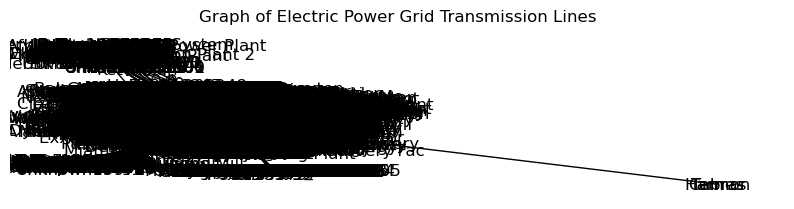

In [150]:
   
# Plot the graph
fig, ax = plt.subplots(figsize=(10, 10))
gdf_exploded.plot(ax=ax, color='gray', linewidth=0.5)
# for edge in G.edges(data=True):
#     if isinstance(edge[2]['geometry'], list):  # Handle MultiLineString
#         for line in edge[2]['geometry']:
#             x, y = line.xy
#             ax.plot(x, y, color='blue', linewidth=1, alpha=0.5)
#     else:
#         x, y = edge[2]['geometry'].xy
#         ax.plot(x, y, color='blue', linewidth=1, alpha=0.5)
nx.draw(G, nx.get_node_attributes(G, 'pos'), with_labels=True, node_size=0)
plt.title('Graph of Electric Power Grid Transmission Lines')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [151]:
# len(G.edges)
list(G.edges)[0:1000:None]

[('Waters River', 'Tap136228'),
 ('Waters River', 'Tap136227'),
 ('Waters River', 'Riser174342'),
 ('Waters River', 'Not Available'),
 ('Tap136228', 'Tap136230'),
 ('Tap136228', 'Tap136226'),
 ('Phillips Bend', 'John Sevier'),
 ('Phillips Bend', 'Pocket North'),
 ('Phillips Bend', 'Volunteer'),
 ('Phillips Bend', 'Tap151036'),
 ('Phillips Bend', 'Sullivan'),
 ('Phillips Bend', 'Nagel'),
 ('Phillips Bend', 'Unknown170436'),
 ('John Sevier', 'Tap152082'),
 ('John Sevier', 'Tap152085'),
 ('John Sevier', 'Rogersville'),
 ('John Sevier', 'Tap152083'),
 ('John Sevier', 'Tap152086'),
 ('John Sevier', 'Tap162666'),
 ('John Sevier', 'Tusculum'),
 ('John Sevier', 'Greeneville'),
 ('John Sevier', 'Tap152105'),
 ('John Sevier', 'Tap152081'),
 ('John Sevier', 'Tap152084'),
 ('John Sevier', 'Not Available'),
 ('John Sevier', 'Unknown176322'),
 ('Tap140359', 'Tap140373'),
 ('Tap140359', 'Tap140362'),
 ('Tap140359', 'Walesville'),
 ('Tap140373', 'Vahnundasis'),
 ('Tap140373', 'Tap140363'),
 ('Gentilly

In [153]:
len(G.nodes)
# print(G.nodes())

67802

In [155]:
len(G.edges)

87889

In [156]:

# Compute network diagnostics
degree = nx.degree(G)
degree_centrality = nx.degree_centrality(G)
# betweenness_centrality = nx.betweenness_centrality(G)

# # Visualize network graph
# plt.figure(figsize=(8, 6))
# nx.draw(G, with_labels=True, node_size=500, node_color='skyblue', font_size=12)
# plt.title('Network Graph')
# plt.show()

# Plot degree centrality
plt.figure(figsize=(6, 4))
plt.bar(degree_centrality.keys(), degree_centrality.values())
plt.xlabel('Node')
plt.ylabel('Degree Centrality')
plt.title('Degree Centrality')
plt.show()

# # Plot betweenness centrality
# plt.figure(figsize=(6, 4))
# plt.bar(betweenness_centrality.keys(), betweenness_centrality.values())
# plt.xlabel('Node')
# plt.ylabel('Betweenness Centrality')
# plt.title('Betweenness Centrality')
# plt.show()


KeyboardInterrupt: 

In [161]:
degree

DegreeView({'Waters River': 4, 'Tap136228': 3, 'Phillips Bend': 7, 'John Sevier': 14, 'Tap140359': 3, 'Tap140373': 3, 'Gentilly Road': 4, 'Michoud Station': 9, 'Unknown137689': 2, 'Tap137690': 3, 'Unknown112122': 2, 'Unknown112349': 2, 'Chelsea Substation': 2, 'Revere': 2, 'Oneida': 13, 'Vahnundasis': 6, 'Dewitt': 14, 'Rock Creek': 14, 'Unknown113712': 4, 'Tap137253': 3, 'Unknown110163': 1, 'Tap142760': 3, 'Unknown117111': 2, 'Hawthorne': 20, 'Unknown120901': 1, 'Tap150391': 3, 'Tap146080': 3, 'Northwest Jackson': 1, 'Tap121270': 3, 'Unknown121273': 1, 'Unknown113813': 5, 'Tap148666': 3, 'St Francis Energy Facility': 5, 'Tap154742': 3, 'Unknown130916': 1, 'Tap134828': 3, 'Tap142649': 3, 'Tap142650': 3, 'Unknown114377': 2, 'Tap148337': 3, 'Unknown114019': 1, 'Tap154445': 4, 'Unknown117407': 4, 'Unknown121499': 2, 'Tap140591': 4, 'Holcomb': 10, 'Unknown116792': 5, 'Unknown116876': 2, 'Tap159665': 3, 'Unknown159666': 1, 'Unknown109170': 7, 'Unknown162133': 1, 'Unknown157853': 2, 'Unknown1

In [180]:
degree

DegreeView({'Waters River': 4, 'Tap136228': 3, 'Phillips Bend': 7, 'John Sevier': 14, 'Tap140359': 3, 'Tap140373': 3, 'Gentilly Road': 4, 'Michoud Station': 9, 'Unknown137689': 2, 'Tap137690': 3, 'Unknown112122': 2, 'Unknown112349': 2, 'Chelsea Substation': 2, 'Revere': 2, 'Oneida': 13, 'Vahnundasis': 6, 'Dewitt': 14, 'Rock Creek': 14, 'Unknown113712': 4, 'Tap137253': 3, 'Unknown110163': 1, 'Tap142760': 3, 'Unknown117111': 2, 'Hawthorne': 20, 'Unknown120901': 1, 'Tap150391': 3, 'Tap146080': 3, 'Northwest Jackson': 1, 'Tap121270': 3, 'Unknown121273': 1, 'Unknown113813': 5, 'Tap148666': 3, 'St Francis Energy Facility': 5, 'Tap154742': 3, 'Unknown130916': 1, 'Tap134828': 3, 'Tap142649': 3, 'Tap142650': 3, 'Unknown114377': 2, 'Tap148337': 3, 'Unknown114019': 1, 'Tap154445': 4, 'Unknown117407': 4, 'Unknown121499': 2, 'Tap140591': 4, 'Holcomb': 10, 'Unknown116792': 5, 'Unknown116876': 2, 'Tap159665': 3, 'Unknown159666': 1, 'Unknown109170': 7, 'Unknown162133': 1, 'Unknown157853': 2, 'Unknown1

In [173]:
degree_hist = nx.degree_histogram(G) 
degree_hist = np.array(degree_hist, dtype=float)

In [179]:
min(degree_hist)

0.0

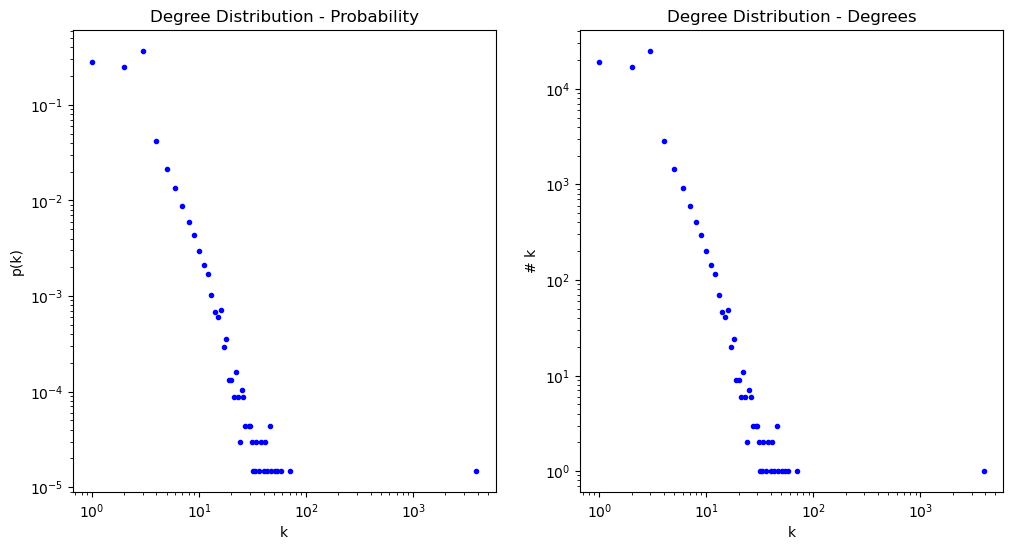

CPU times: user 1.17 s, sys: 90.9 ms, total: 1.26 s
Wall time: 739 ms


In [168]:
%%time

def plot_degree_dist(G):
    fig = plt.figure(figsize=(12,6))
    gs = gridspec.GridSpec(1, 2, )
    degree_hist = nx.degree_histogram(G) 
    degree_hist = np.array(degree_hist, dtype=float)
    degree_prob = degree_hist/G.number_of_nodes()
    
    ax = plt.subplot(gs[0])
    plt.plot(np.arange(degree_prob.shape[0]),degree_prob,'b.')
    plt.xlabel('k')
    plt.ylabel('p(k)')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Degree Distribution - Probability')
    
    ax = plt.subplot(gs[1])
    plt.plot(np.arange(degree_hist.shape[0]),degree_hist,'b.')
    plt.xlabel('k')
    plt.ylabel('# k')
    plt.yscale('log')
    plt.xscale('log')
    plt.title('Degree Distribution - Degrees')
    
    plt.show()
    
plot_degree_dist(G)

In [181]:
sorted_degrees_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)
sorted_degrees_nodes[0:100]

[('Not Available', 3887),
 ('Midway', 70),
 ('Columbia', 58),
 ('Northeast', 54),
 ('Franklin', 51),
 ('Terminal', 47),
 ('Riverside', 46),
 ('Marion', 46),
 ('Northwest', 46),
 ('Dead Head', 43),
 ('Southwest', 41),
 ('Valley', 41),
 ('Wayne', 40),
 ('Highland', 38),
 ('Goshen', 38),
 ('Madison', 36),
 ('Davis', 34),
 ('Jefferson', 34),
 ('Monroe', 33),
 ('Miami', 32),
 ('Benton', 31),
 ('Nelson', 31),
 ('Fayetteville', 30),
 ('Cherokee', 30),
 ('Clinton', 30),
 ('Lee', 29),
 ('Anderson', 29),
 ('Allen', 29),
 ('Clay', 27),
 ('Athens', 27),
 ('Seminole', 27),
 ('Clark', 26),
 ('Sunnyside', 26),
 ('Jackson', 26),
 ('Summit', 26),
 ('West', 26),
 ('Lexington', 26),
 ('University', 25),
 ('Tazewell', 25),
 ('Holbrook', 25),
 ('Harrison', 25),
 ('Wilson', 25),
 ('Montgomery', 25),
 ('Shelby', 25),
 ('Freeport', 24),
 ('Switch', 24),
 ('Pleasant Valley', 23),
 ('Lockport', 23),
 ('Northside', 23),
 ('Lincoln', 23),
 ('Cottonwood', 23),
 ('Bell', 23),
 ('Leeds', 22),
 ('Perry', 22),
 ('Shaw

In [182]:
sorted_degrees_nodes[0][0]

'Not Available'

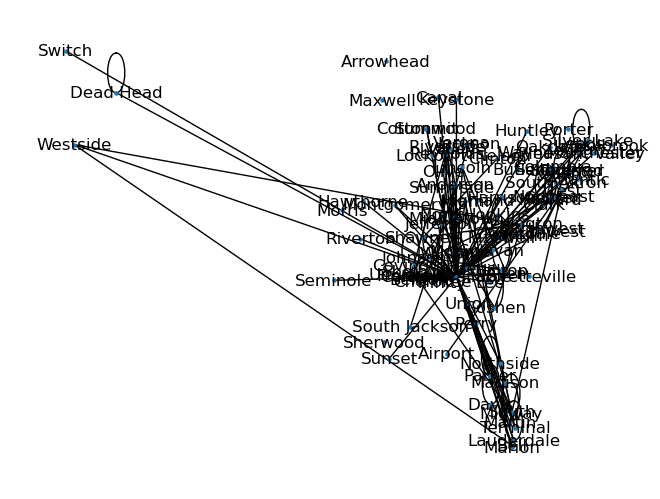

In [228]:
# Create a subgraph containing only the nodes with the specified titles
subgraph_nodes = [node[0] for node in sorted_degrees_nodes[0:100]]
H = G.subgraph(subgraph_nodes)

# Plot the subgraph
# pos = nx.spring_layout(H)  # Position the nodes using a spring layout
nx.draw(H,nx.get_node_attributes(G, 'pos'),with_labels=True,node_size=5)#, pos, with_labels=True, node_color='lightblue', node_size=100)
plt.show()




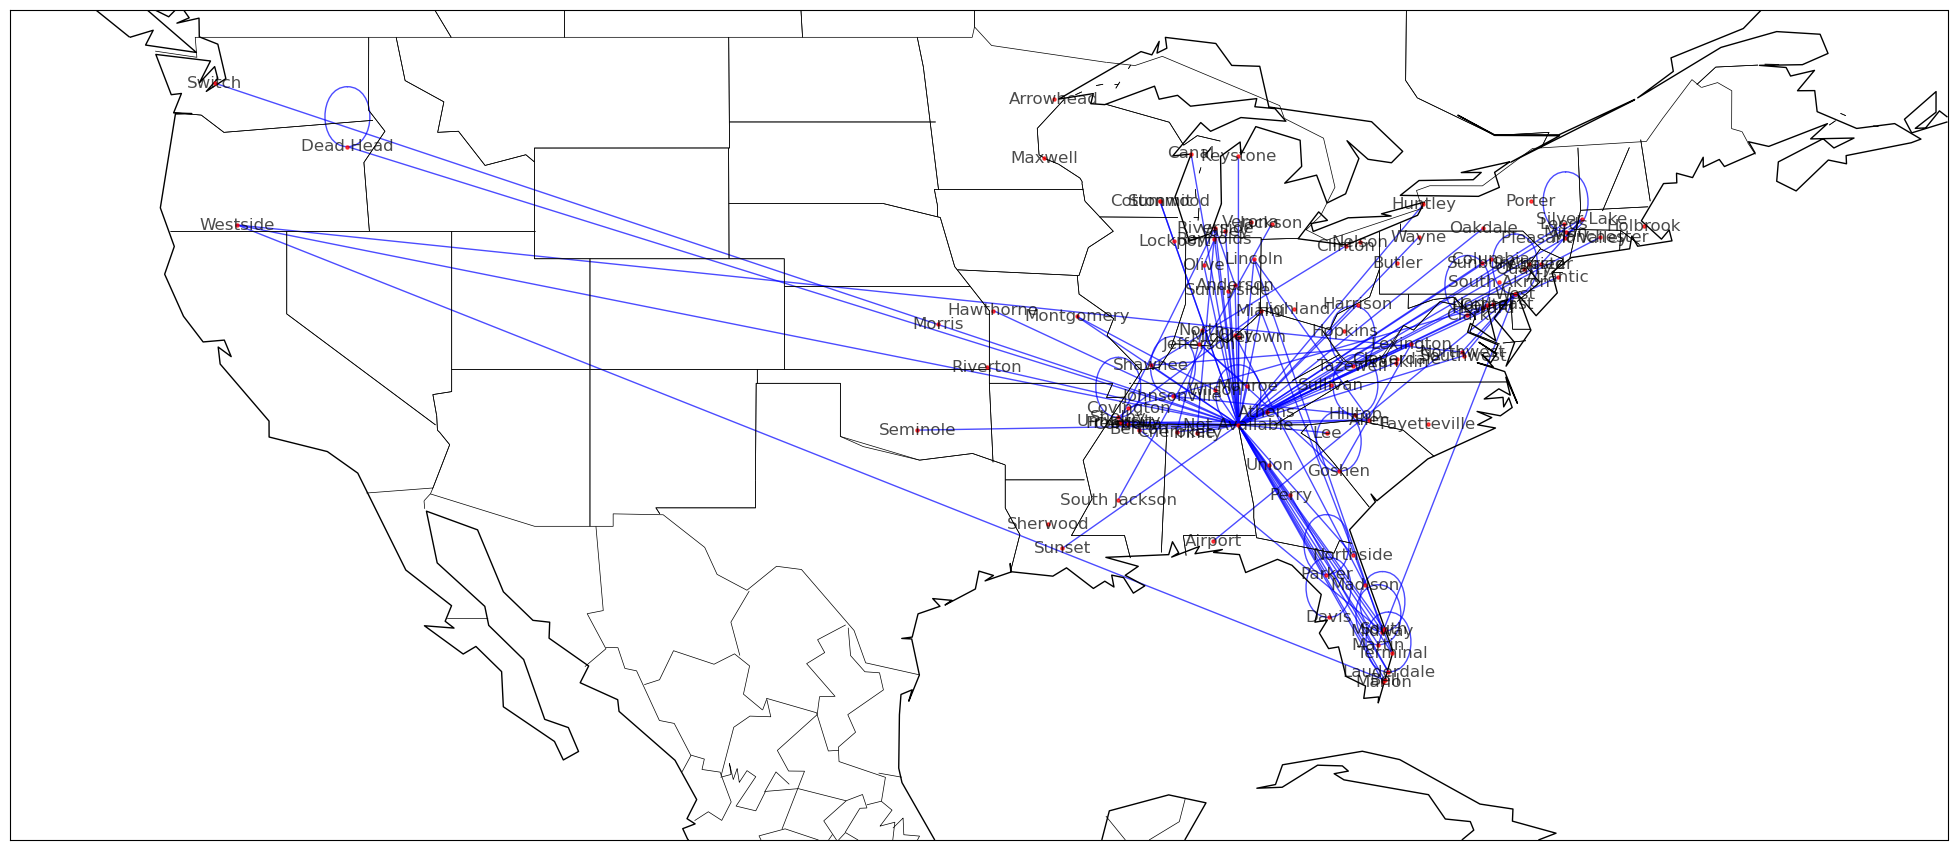

In [229]:
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap


# Create a Basemap object
plt.figure(figsize=(25,25))
m = Basemap(llcrnrlon=-130, llcrnrlat=20, urcrnrlon=-60, urcrnrlat=50,
            epsg=4326, lat_1=33, lat_2=45, lon_0=-95)
# map = Basemap(llcrnrlon=3.75,llcrnrlat=39.75,urcrnrlon=4.35,urcrnrlat=40.15, resolution = 'h', epsg=5520)
# Plot the map
m.drawcoastlines()
m.drawcountries()
m.drawstates()


nx.draw_networkx(H, nx.get_node_attributes(H, 'pos'), node_size=5, node_color='r', edge_color = 'b', alpha=0.7,with_labels=True)


# # Plot the nodes
# # pos = {node: (lon, lat) for node, (lon, lat) in nx.get_node_attributes(H, 'pos').items()}
# nx.draw_networkx_nodes(H, nx.get_node_attributes(H, 'pos'), node_size=100, node_color='r', alpha=0.7)

# # Draw edges if needed
# nx.draw_networkx_edges(H, nx.get_node_attributes(H, 'pos'), width=1.0, alpha=0.5)

# Show the plot
plt.show()


In [217]:
G.nodes['Celilo']#,'Sylmar East']

{'pos': (-121.11307855726069, 45.59460750584903)}

In [218]:
G.nodes['Sylmar East']

{'pos': (-118.48113126292664, 34.31252825692502)}

In [51]:
import momepy

In [54]:
G2 = momepy.gdf_to_nx(gdf_exploded, approach="primal")

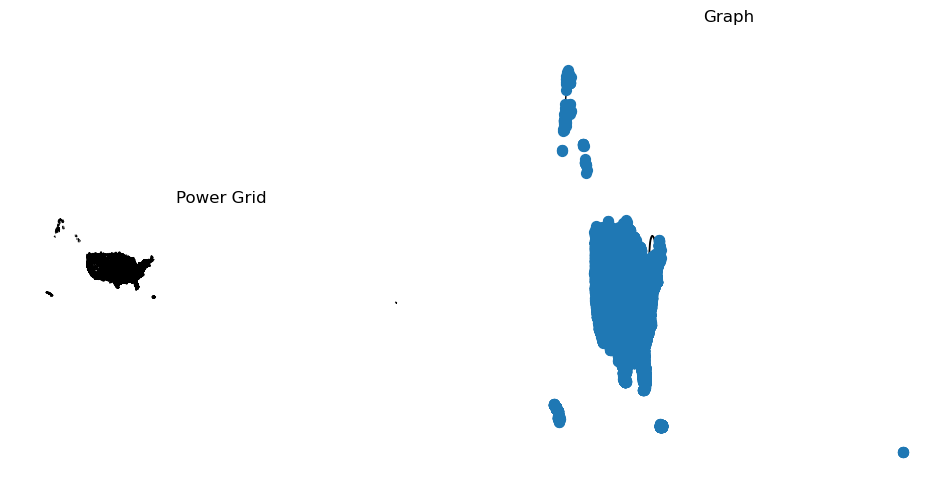

In [57]:
# Plot
f, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
gdf_exploded.plot(color="k", ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("Power Grid", "Graph")[i])
    facet.axis("off")
    try:  # For issues with downloading/parsing in CI
        add_basemap(facet)
    except:
        pass
nx.draw(
    
    G2, {n: [n[0], n[1]] for n in list(G2.nodes)}, ax=ax[1], node_size=50
)

In [59]:
degree_centrality = nx.degree_centrality(G2)


In [60]:
degree_centrality

{(-7895730.4795, 5242757.6214): 5.341880341880342e-05,
 (-7895714.4061, 5242835.5035): 4.0064102564102564e-05,
 (-9235201.9856, 4352619.8026): 0.0002403846153846154,
 (-9218131.4903, 4364200.3466): 0.00013354700854700856,
 (-8386149.9009, 5325598.7488): 4.0064102564102564e-05,
 (-8387310.7626, 5330863.8355): 4.0064102564102564e-05,
 (-10011772.0539, 3504713.3356): 0.0001201923076923077,
 (-10007333.6566, 3508553.5062): 5.341880341880342e-05,
 (-10081770.7547, 5103118.3995): 2.670940170940171e-05,
 (-10077702.0719, 5107877.9591): 4.0064102564102564e-05,
 (-9666110.1309, 4009360.6902): 2.670940170940171e-05,
 (-9664118.5386, 4013027.5595): 2.670940170940171e-05,
 (-7906450.8107, 5220314.3419): 2.670940170940171e-05,
 (-7904537.7479, 5221520.0717): 2.670940170940171e-05,
 (-8386153.6514, 5325530.8196): 8.012820512820513e-05,
 (-8419218.915, 5327527.8297): 9.348290598290598e-05,
 (-10078404.8134, 5132702.9909): 2.670940170940171e-05,
 (-10051637.6597, 5129723.4009): 5.341880341880342e-05,


In [63]:
degree = dict(nx.degree(G2))

In [64]:
degree

{(-7895730.4795, 5242757.6214): 4,
 (-7895714.4061, 5242835.5035): 3,
 (-9235201.9856, 4352619.8026): 18,
 (-9218131.4903, 4364200.3466): 10,
 (-8386149.9009, 5325598.7488): 3,
 (-8387310.7626, 5330863.8355): 3,
 (-10011772.0539, 3504713.3356): 9,
 (-10007333.6566, 3508553.5062): 4,
 (-10081770.7547, 5103118.3995): 2,
 (-10077702.0719, 5107877.9591): 3,
 (-9666110.1309, 4009360.6902): 2,
 (-9664118.5386, 4013027.5595): 2,
 (-7906450.8107, 5220314.3419): 2,
 (-7904537.7479, 5221520.0717): 2,
 (-8386153.6514, 5325530.8196): 6,
 (-8419218.915, 5327527.8297): 7,
 (-10078404.8134, 5132702.9909): 2,
 (-10051637.6597, 5129723.4009): 4,
 (-9104342.2828, 5072771.3863): 3,
 (-9104238.8455, 5072743.1775): 4,
 (-10026235.2198, 3709543.7457): 3,
 (-10033332.3913, 3707992.7712): 1,
 (-10517694.7216, 4740783.0263): 2,
 (-10517341.2376, 4740227.4002): 12,
 (-8971908.9966, 4065596.719): 3,
 (-8972178.3663, 4065538.3188): 1,
 (-10046315.4016, 3807983.3811): 1,
 (-10046364.856, 3811090.1743): 3,
 (-92540

In [71]:
len(degree_centrality.keys())

74881

In [69]:
gdf_exploded

OBJECTID_1  OBJECTID      ID          TYPE         STATUS NAICS_CODE  \
0     0           1         1  100511  AC; Overhead     In Service     221121   
1     0           2         2  140809  AC; Overhead     In Service     221121   
2     0           3         3  140837  AC; Overhead     In Service     221121   
3     0           4         4  140811  AC; Overhead     In Service     221121   
4     0           5         5  140813  AC; Overhead     In Service     221121   
...             ...       ...     ...           ...            ...        ...   
94211 0       94212     94212  313969  AC; Overhead     In Service     221121   
94212 0       94213     94213  313970  AC; Overhead     In Service     221121   
94213 0       94214     94214  202495  AC; Overhead  Not Available     221121   
94214 0       94215     94215  202496  AC; Overhead  Not Available     221121   
94215 0       94216     94216  166911  AC; Overhead  Not Available     221121   

                                           NAICS_DESC  \
0     0  Electric Bulk Power Transmission and Control   
1     0  Electric Bulk Power Transmission and Control   
2     0  Electric Bulk Power Transmission and Control   
3     0  Electric Bulk Power Transmission and Control   
4     0  Electric Bulk Power Transmission and Control   
...                                               ...   
94211 0  Electric Bulk Power Transmission and Control   
94212 0  Electric Bulk Power Transmission and Control   
94213 0  Electric Bulk Power Transmission and Control   
94214 0  Electric Bulk Power Transmission and Control   
94215 0  Electric Bulk Power Transmission and Control   

                                                    SOURCE  \
0     0                          Imagery, EIA 861, EIA 860   
1     0                                   Imagery, EIA 860   
2     0  Imagery, https://www9.nationalgridus.com/oasis...   
3     0                             Imagery, OpenStreetMap   
4     0                                   Imagery, EIA 860   
...                                                    ...   
94211 0                                            Imagery   
94212 0                                            Imagery   
94213 0                                            Imagery   
94214 0                                            Imagery   
94215 0                                            Imagery   

                  SOURCEDATE     VAL_METHOD             VAL_DATE  \
0     0  2016-11-08T00:00:00        Imagery  2017-03-27T00:00:00   
1     0  2014-04-16T00:00:00        Imagery  2017-02-15T00:00:00   
2     0  2015-06-16T00:00:00        Imagery  2019-03-05T00:00:00   
3     0  2014-06-20T00:00:00        Imagery  2017-03-20T00:00:00   
4     0  2016-10-04T00:00:00  Imagery/other  2018-05-09T00:00:00   
...                      ...            ...                  ...   
94211 0  2018-08-28T00:00:00  Imagery/other  2022-05-24T00:00:00   
94212 0  2018-10-16T00:00:00  Imagery/other  2022-05-24T00:00:00   
94213 0  2019-04-10T00:00:00        Imagery  2019-04-10T00:00:00   
94214 0  2019-04-10T00:00:00        Imagery  2019-04-10T00:00:00   
94215 0  2019-04-10T00:00:00        Imagery  2019-04-10T00:00:00   

                                                   OWNER  VOLTAGE VOLT_CLASS  \
0     0                                    Not Available    115.0    100-161   
1     0                               Kingsport Power Co    161.0    100-161   
2     0                       Niagara Mohawk Power Corp.    115.0    100-161   
3     0                         Entergy New Orleans, Llc    115.0    100-161   
4     0                            Midamerican Energy Co    161.0    100-161   
...                                                  ...      ...        ...   
94211 0      Sulphur Springs Valley Electric Cooperative     69.0  Under 100   
94212 0  Graham County Electric Cooperative Incorporated     69.0  Under 100   
94213 0                            City Of Gering - (Ne)    115.0    